#Grad_CAM: Gradient Weighted Class Activation Mapping

The rise of convolutional Neural Network has proven to be a break through in machine learning, enabling deep nerual networks to provide excellent performance in various vision related tasks varying from image classification to visual question answering. But with this benefit comes a drawback that as the deep NNs have become intricate, they have also become more harder to interpret.


---



Explainable AI is an approach that allows developers and users to understand the behaviour of different neural networks. One of the techniques of explainable AI is Grad_CAM (Gradient Weighted Class Activation Mapping).

Grad_cam is a rough localized map that hightlights the areas of an image that are important for the model in predicting a cartain target class. It uses the gradients of any target class flowing into the final convolutional layer to produce a localization map.

Following are the steps for generating a Grad_CAM:
  1. Derivative of the raw score of the target class with respect to the last convolution ouput
  2. Global Average Pooling of the derivative
  3. Linear combination with the last convolution output
  4. Normalizating the result
  5. Superimposing the heatmap and the original image

(details of each step will be provided when implemented)

In this notebook, we will first make a model via transfer learning having ResNet50V2 as the base model, however any pre-trained CNN model can be used, that will serve as the foundation of the grad_cam model. The grad_cam model will be used to get the last convolutional output as well as the softmax predictions.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing dependencies

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import numpy as np
from tensorflow import keras
from keras.layers import Input, Lambda, Dense, Flatten, Rescaling
from keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from os import listdir, path
from skimage.util import random_noise
from skimage import img_as_float
import math
import cv2
import os
import PIL
import shutil
import matplotlib.cm as cm

# Functions

In [ ]:
#function for creating model
#returns model, its inputs, Xception's last conv output, the whole model's outputs
def create_model_base(classes, activation, base):
  inputs = keras.Input(shape = (160,160,3))
  #normalizing pixel values
  r = Rescaling(scale = 1./255)(inputs)
  x = base(r, training = False)
  gap = keras.layers.GlobalAveragePooling2D()(x)
  outputs = keras.layers.Dense(classes ,activation = activation)(gap)
  model = keras.Model(inputs, outputs)

  if classes > 2:
    loss_s = keras.losses.CategoricalCrossentropy()
  else:
    loss_s = keras.losses.BinaryCrossentropy()

  model.compile(
    loss = loss_s,
    optimizer = keras.optimizers.Adam(0.001),
    metrics = ["accuracy"]
  )

  return model

In [ ]:
#function for creating model
#returns model, its inputs, Xception's last conv output, the whole model's outputs
def create_model_mod_base(classes, activation, base):
  inputs = keras.Input(shape = (160,160,3))
  #normalizing pixel values
  r = Rescaling(scale = 1./255)(inputs)
  x = base(r, training = False)
  gap = keras.layers.GlobalAveragePooling2D()(x)
  outputs = keras.layers.Dense(classes ,activation = activation)(gap)
  model = keras.Model(inputs, outputs)

  if classes > 2:
    loss_s = keras.losses.CategoricalCrossentropy()
  else:
    loss_s = keras.losses.BinaryCrossentropy()

  model.compile(
    loss = loss_s,
    optimizer = keras.optimizers.Adam(0.001),
    metrics = ["accuracy"]
  )

  return model, inputs, x, outputs

In [ ]:
#function that creates a gradcam model and returns it
def create_grad_model_base(weights, classes, activation, base):
  model_mod, input, x, output = create_model_mod_base(classes, activation, base)
  #lodaing weights of already trained model
  model_mod.load_weights(weights)
  grad_model = Model(input, [x, output])
  return grad_model

In [ ]:
def create_heatmaps_multi(grad_model, imgs, class_index, choose_mode = 0):
  #removing the activation of last layer to get the raw scores rather than predictions
  grad_model.layers[-1].activation = None

  with tf.GradientTape() as tape:
    #predicting the image to get the the last conv output and predictions
    maps, preds = grad_model(imgs)
    #getting the raw score of the interested class
    if choose_mode == 1:
      class_index = tf.argmax(preds[0])
    class_channel = preds[:, class_index]

  # TAKING THE DERIVATIVE
  # the shape of the derivative will be the same as the shape of last conv output
  grads = tape.gradient(class_channel, maps)

  gap_grads = []
  for i in grads:
    # global average pooling of each feature map
    gap = tf.reduce_mean(i, axis=(0, 1))
    #the lenght of the of the result is equal to the depth of the derivative
    gap_grads.append(gap)
  gap_grads = np.array(gap_grads)

  heatmaps = []
  for i in range(len(maps)):
    #multiplying each pooled value with its correponding feature map
    heatmap = maps[i] @ gap_grads[i][..., tf.newaxis]
    #removing the extra dimensions of value 1
    heatmap = tf.squeeze(heatmap)
    # For visualization purpose, we will normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmaps.append(heatmap)
  heatmaps = np.array(heatmaps)

  if choose_mode == 1:
    preds = class_channel

  return heatmaps, np.array(preds)

In [ ]:
def create_heatmaps_single(grad_model, img, class_index, choose_mode = 0):
  #removing the activation of last layer to get the raw scores rather than predictions
  grad_model.layers[-1].activation = None

  with tf.GradientTape() as tape:
    #predicting the image to get the the last conv output and predictions
    maps, preds = grad_model(img)
    #getting the raw score of the interested class
    if choose_mode == 1:
      class_index = tf.argmax(preds[0])
    class_channel = preds[:, class_index]

  # TAKING THE DERIVATIVE
  # the shape of the derivative will be the same as the shape of last conv output
  grads = tape.gradient(class_channel, maps)

  # global average pooling of each feature map
  gap_grad = tf.reduce_mean(grads, axis=(0, 1, 2))

  #multiplying each pooled value with its correponding feature map
  heatmap = maps @ gap_grad[..., tf.newaxis]
  #removing the extra dimensions of value 1
  heatmap = tf.squeeze(heatmap)
  # print(heatmap)
  # For visualization purpose, we will normalize the heatmap between 0 & 1
  heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
  # heatmap = (heatmap - tf.reduce_min(heatmap)) / (tf.reduce_max(heatmap) - tf.reduce_min(heatmap))

  if choose_mode == 1:
    preds = class_channel

  return heatmap, np.array(preds)

In [ ]:
def superimpose_multi(heatmaps, imgs_org, alpha = 0.4):
  # Rescale heatmaps to a range 0-255 because RGB values range from 0 - 255
  heatmaps = np.uint8(255 * heatmaps)

  # Use jet colormap to colorize the heatmap corresponding the the intensities
  jet = cm.get_cmap("jet")
  # Use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmaps = jet_colors[heatmaps]

  #resizing the heatmaps to original image size
  jet_heatmaps_resized = []
  for i in range(len(jet_heatmaps)):

    # Converting the heatmap from array to image to resize it to the size of the original image
    jet_heatmap = keras.utils.array_to_img(jet_heatmaps[i])
    jet_heatmap = jet_heatmap.resize((imgs_org[i].shape[1], imgs_org[i].shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)
    jet_heatmaps_resized.append(jet_heatmap)

  superimposed_imgs = []
  for i in range(len(jet_heatmaps_resized)):
    # Superimposing the heatmap on original image
    superimposed_img = jet_heatmaps_resized[i] * alpha + imgs_org[i]
    superimposed_img = keras.utils.array_to_img(superimposed_img)
    superimposed_imgs.append(superimposed_img)

  return superimposed_imgs

In [ ]:
def superimpose_single(heatmap, img_org, alpha = 0.4):
  # Rescale heatmap to a range 0-255 because RGB values range from 0 - 255
  heatmap = np.uint8(255 * heatmap)

  # Use jet colormap to colorize the heatmap corresponding the the intensities
  jet = cm.get_cmap("jet")
  # Use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  # Converting the heatmap from array to image to resize it to the size of the original image
  jet_heatmap = keras.utils.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img_org.shape[1], img_org.shape[0]))
  jet_heatmap = keras.utils.img_to_array(jet_heatmap)

  # Superimposing the heatmap on original image
  superimposed_img = jet_heatmap * alpha + img_org
  superimposed_img = keras.utils.array_to_img(superimposed_img)

  return superimposed_img

In [ ]:
#helper function that generates heatmaps and then combine them with their images
def gen_grad_imgs(grad_model, imgs, imgs_org, class_index, alpha = 0.4):
  heatmaps, y_pred = create_heatmaps_multi(grad_model, imgs, class_index)
  # print("y_pred:", y_pred)
  # print("np.argmax(y_pred):", np.argmax(y_pred, axis = 1))

  # if classes == 1:
  #   for i in range(len(y_pred)):
  #       if y_pred[i] > 0.5: y_pred[i] = 1
  #       else: y_pred[i] = 0

  imgs = superimpose_multi(heatmaps, imgs_org, alpha)
  return imgs, y_pred

In [ ]:
#function for displaying given array of images with their true labels and pred labels
def show_imgs(imgs, labels_t, size, cols, labels_f = None, font_size = 10):
  plt.clf()
  plt.figure(figsize = (size[0],size[1]))

  for i in range(len(imgs)):
    plt.subplot(math.ceil(len(imgs)/5),cols,i+1)
    plt.imshow(imgs[i])
    if labels_f is None:
      plt.title("True Label: " + str(labels_t[i]), fontsize = font_size)
    else:
      plt.title("True Label: " + str(labels_t[i]) + "\n" + "Pred Label: " + str(labels_f[i]), fontsize = font_size)
    plt.axis('off')


# Loading data

The data being loaded contains images of cats and dogs that are used for binary classification. Cats are labeled as 1 and dogs are labeled as 0.

In [ ]:
# #loading data for training the model
# train_ds = np.load("/content/drive/MyDrive/Cats_Vs_Dogs_Dataset/images_train.npy")
# test_ds = np.load("/content/drive/MyDrive/Cats_Vs_Dogs_Dataset/images_test.npy")
# cv_ds = np.load("/content/drive/MyDrive/Cats_Vs_Dogs_Dataset/images_valid.npy")

# labels_train = np.load("/content/drive/MyDrive/Cats_Vs_Dogs_Dataset/labels_train.npy")
# labels_test = np.load("/content/drive/MyDrive/Cats_Vs_Dogs_Dataset/labels_test.npy")
# labels_cv = np.load("/content/drive/MyDrive/Cats_Vs_Dogs_Dataset/labels_valid.npy")

In [ ]:
# #visually displaying some images with their ground truth labels
# show_imgs(cv_ds[:5], labels_cv[:5], [10,10], 5, labels_f = None, font_size = 10)

In [ ]:
# #making one hot vectors from labels
# # 0 is dog, [0,1] is dog
# # 1 is cat, [1,0] is cat
# labels_train_new = []
# for i in range(len(labels_train)):
#   if labels_train[i] == 0:
#     labels_train_new.append([0,1])
#   elif labels_train[i] == 1:
#     labels_train_new.append([1,0])

# labels_train = np.array(labels_train_new)

In [ ]:
# labels_cv_new = []
# for i in range(len(labels_cv)):
#   if labels_cv[i] == 0:
#     labels_cv_new.append([0,1])
#   elif labels_cv[i] == 1:
#     labels_cv_new.append([1,0])

# labels_cv = np.array(labels_cv_new)

In [ ]:
# labels_test_new = []
# for i in range(len(labels_test)):
#   if labels_test[i] == 0:
#     labels_test_new.append([0,1])
#   elif labels_test[i] == 1:
#     labels_test_new.append([1,0])

# labels_test = np.array(labels_test_new)

# Loading Tensorflow dataset

In [ ]:
import tensorflow_datasets as tfds

#loading cats_vs_dogs dataset from tensorflow
#cats_vs_dogs dataset only has train split, thats why we get a few images from the same split as test images
dataset_train = tfds.load("cats_vs_dogs", split = 'train[:5000]', as_supervised=True)
dataset_test = tfds.load("cats_vs_dogs", split = 'train[2000:3000]', as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteHUE7SL/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [ ]:
print(len(dataset_train))
print(len(dataset_test))

5000
1000


In [ ]:
#getting img matrixs and labels of each image
imgs_train_ds = dataset_train.map(lambda images, labels: images)
labels_train_ds = dataset_train.map(lambda images, labels: labels)

imgs_test_ds = dataset_test.map(lambda images, labels: images)
labels_test_ds = dataset_test.map(lambda images, labels: labels)

In [ ]:
#for train images
#getting those images which have minimum 224 by 224 dimensions
#saving the indices of such images to get their corresponding labels
imgs_train_big = []
indexes = []

for i, img in enumerate(imgs_train_ds):
  if(img.shape[0] >= 224 and img.shape[1] >= 224):
    imgs_train_big.append(np.array(img))
    indexes.append(i)

labels_train_big = []
for i in labels_train_ds:
  labels_train_big.append(i)

labels_train_big = np.array(labels_train_big)
labels_train_big = labels_train_big[indexes]

In [ ]:
#for test images
#getting those images which have minimum 224 by 224 dimensions
#saving the indices of such images to get their corresponding labels

imgs_test_big = []
indexes = []

for i, img in enumerate(imgs_test_ds):
  if(img.shape[0] >= 224 and img.shape[1] >= 224):
    imgs_test_big.append(np.array(img))
    indexes.append(i)

labels_test_big = []
for i in labels_test_ds:
  labels_test_big.append(i)

labels_test_big = np.array(labels_test_big)
labels_test_big = labels_test_big[indexes]

In [ ]:
#for train
#resizing all the images to 224 by 224 dimension
for i in range(len(imgs_train_big)):
  imgs_train_big[i] = np.array(tf.image.resize(imgs_train_big[i], [224,224])).astype('uint8')
imgs_train_big = np.array(imgs_train_big)
print(imgs_train_big.shape)

(4462, 224, 224, 3)


In [ ]:
#for test
#resizing all the images to 224 by 224 dimension
for i in range(len(imgs_test_big)):
  imgs_test_big[i] = np.array(tf.image.resize(imgs_test_big[i], [224,224])).astype('uint8')
imgs_test_big = np.array(imgs_test_big)
print(imgs_test_big.shape)

(906, 224, 224, 3)


In [ ]:
print(len(imgs_train_big))
print(len(labels_train_big))
print(len(imgs_test_big))
print(len(labels_test_big))

4462
4462
906
906


In [ ]:
#for train
#creating labels for cats and dogs images
cat_indexes = [] #will store the indices of cat images
dog_indexes = [] #will store the indices of dog images
cats_l =[] #will store the lables of cat images
dogs_l =[] #will store the lables of dog images

for i in range(len(labels_train_big)):
  if labels_train_big[i] == 0:
    cat_indexes.append(i)
    cats_l.append(1)
  else:
    dog_indexes.append(i)
    dogs_l.append(0)

print(len(cat_indexes))
print(len(dog_indexes))

#getting the cat images and dog images
cats = np.array(imgs_train_big)[cat_indexes]
dogs = np.array(imgs_train_big)[dog_indexes]

#combining the cats and dogs images and labels to get single arrays of train images and train labels
imgs_train_big = list(cats[:500]) + list(dogs[:500])
labels_train_big = cats_l[:500] + dogs_l[:500]

2233
2229


In [ ]:
print(len(imgs_train_big))
print(len(labels_train_big))

1000
1000


In [ ]:
#for tet
#creating labels for cats and dogs images
cat_indexes = [] #will store the indices of cat images
dog_indexes = [] #will store the indices of dog images
cats_l =[] #will store the lables of cat images
dogs_l =[] #will store the lables of dog images

for i in range(len(labels_test_big)):
  if labels_test_big[i] == 0:
    cat_indexes.append(i)
    cats_l.append(1)
  else:
    dog_indexes.append(i)
    dogs_l.append(0)

print(len(cat_indexes))
print(len(dog_indexes))

#getting the cat images and dog images
cats = np.array(imgs_test_big)[cat_indexes]
dogs = np.array(imgs_test_big)[dog_indexes]

#combining the cats and dogs images and labels to get single arrays of train images and train labels
imgs_test_big = list(cats[:100]) + list(dogs[:100])
labels_test_big = cats_l[:100] + dogs_l[:100]

431
475


In [ ]:
print(len(imgs_test_big))
print(len(labels_test_big))

200
200


In [ ]:
#shuffling the train and test arrays
indices = np.arange(len(imgs_train_big))
np.random.shuffle(indices)
imgs_train_big = np.array(imgs_train_big)[indices]
labels_train_big = np.array(labels_train_big)[indices]

indices = np.arange(len(imgs_test_big))
np.random.shuffle(indices)
imgs_test_big = np.array(imgs_test_big)[indices]
labels_test_big = np.array(labels_test_big)[indices]

In [ ]:
print(imgs_train_big.shape)
print(labels_train_big.shape)
print(imgs_test_big.shape)
print(labels_test_big.shape)

(1000, 224, 224, 3)
(1000,)
(200, 224, 224, 3)
(200,)


In [ ]:
#creating one hot vectors of labels of train and test
labels_train_new_big = []
for i in range(len(labels_train_big)):
  if labels_train_big[i] == 0:
    labels_train_new_big.append([0,1])
  else:
    labels_train_new_big.append([1,0])

labels_train_new_big = np.array(labels_train_new_big)

labels_test_new_big = []
for i in range(len(labels_test_big)):
  if labels_test_big[i] == 0:
    labels_test_new_big.append([0,1])
  else:
    labels_test_new_big.append([1,0])

labels_test_new_big = np.array(labels_test_new_big)

<Figure size 640x480 with 0 Axes>

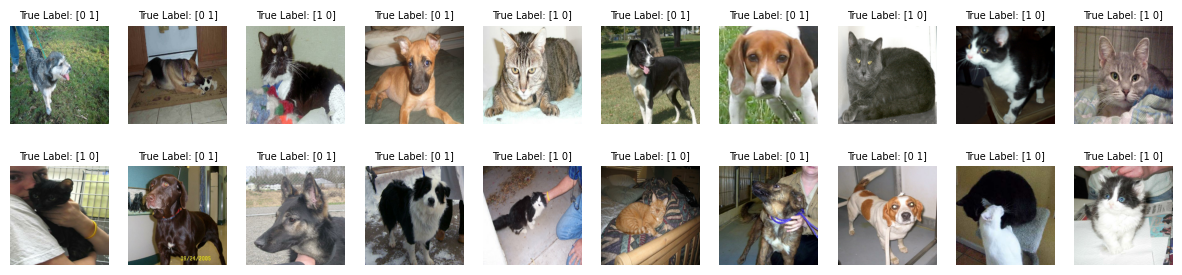

In [ ]:
show_imgs(imgs_train_big[:20], labels_train_new_big[:20], [15,7], 10, font_size = 7)

<Figure size 640x480 with 0 Axes>

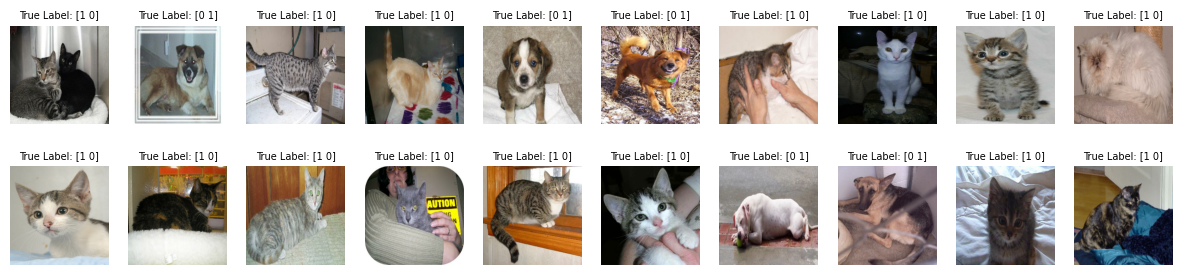

In [ ]:
show_imgs(imgs_test_big[:20], labels_test_new_big[:20], [15,7], 10, font_size = 7)

In [ ]:
# imgs_train_big = tf.image.resize(imgs_train_big, [160,160])
# imgs_test_big = tf.image.resize(imgs_test_big, [160,160])

In [ ]:
imgs_train_big.shape

(1000, 224, 224, 3)

# Loading base model

In [ ]:
#seeting seed for uniform randomization
tf.random.set_seed(1234)

ResNet50V2 has been selected as the base model because it is an excellent model for transfer learning providing good accuracy in image classification tasks. If you wish you can use any transfer learning model you like.

Visit https://keras.io/api/applications/ for more details.

In [ ]:
base_model = keras.applications.ResNet50V2(
    # weights = "../input/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5",
    input_shape = (224,224,3),
    include_top = False,)

base_model.trainable = False

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
# keras.utils.plot_model(base_model)

In [ ]:
#printing few of the last layers of the base model
Total_layers = len(base_model.layers)
for i in range(Total_layers-10, Total_layers):
  print(base_model.layers[i].name)
print()
print("Total layers:", Total_layers)

conv5_block3_1_bn
conv5_block3_1_relu
conv5_block3_2_pad
conv5_block3_2_conv
conv5_block3_2_bn
conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_out
post_bn
post_relu

Total layers: 190


# Creating transfer learning model

The transfer learning model will contain the base model with addition to:
  1. Input Layer: specifying the input of the model
  2. Rescalling layer: for normalizing the pixel values of images
  3. Global Average Pooling: to flatten the output of the last CNN block for the Dense layer
  4. Dense Layer: having 2 units with softmax activation to make prediction for dog and cat classes

The base model is set to trainable = False, meaning it will not be trained and only the dense layer will be trained as we do not want to change the learned featured of the base model.

In [ ]:
#controls for our model

#no of classes of classification
classes = 2

#activation of last dense layer
activation = "softmax"

#loss function for our model
#if binary classification loss will be BinaryCrossentropy, if multiclass classification loss will be CategoricalCrossentropy
loss_s = keras.losses.BinaryCrossentropy()

In [ ]:
#building our model
#normalizing pixel values
#adding the base model
#global average pooling to flatten the last conv layer output
#softmax layer to make predictions

inputs = keras.Input(shape = (224,224,3))
r = Rescaling(scale = 1./255)(inputs)
last_conv_output = base_model(r, training = False)
gap = keras.layers.GlobalAveragePooling2D()(last_conv_output)
outputs = keras.layers.Dense(classes, activation = activation)(gap)
model = keras.Model(inputs, outputs)

model.compile(
  loss = loss_s,
  optimizer = keras.optimizers.Adam(0.001), # learning rate = 0.001
  metrics = ["accuracy"]
)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23568898 (89.91 MB)
Trainable params: 4098 (16.01 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________

## Training the Model

You need to choose the values of hyperparameters that prove to be good for the model's accuracy.

In [ ]:
# history = model.fit(train_ds, labels_train,
#                     validation_data = (cv_ds, labels_cv),
#                     epochs = 10, batch_size = 64)

history = model.fit(imgs_train_big, labels_train_new_big,
                    validation_data = (imgs_test_big, labels_test_new_big),
                    epochs = 10, batch_size = 64)

Epoch 1/10
16/16 [==============================] - 19s 400ms/step - loss: 0.3480 - accuracy: 0.8960 - val_loss: 0.1258 - val_accuracy: 0.9700
Epoch 2/10
16/16 [==============================] - 3s 204ms/step - loss: 0.0937 - accuracy: 0.9790 - val_loss: 0.0658 - val_accuracy: 0.9700
Epoch 3/10
16/16 [==============================] - 3s 193ms/step - loss: 0.0607 - accuracy: 0.9800 - val_loss: 0.0562 - val_accuracy: 0.9800
Epoch 4/10
16/16 [==============================] - 3s 200ms/step - loss: 0.0487 - accuracy: 0.9890 - val_loss: 0.0504 - val_accuracy: 0.9800
Epoch 5/10
16/16 [==============================] - 3s 201ms/step - loss: 0.0399 - accuracy: 0.9920 - val_loss: 0.0450 - val_accuracy: 0.9900
Epoch 6/10
16/16 [==============================] - 3s 203ms/step - loss: 0.0341 - accuracy: 0.9930 - val_loss: 0.0422 - val_accuracy: 0.9900
Epoch 7/10
16/16 [==============================] - 3s 205ms/step - loss: 0.0293 - accuracy: 0.9950 - val_loss: 0.0384 - val_accuracy: 0.9900
Epoch

In [ ]:
#saving the weights of the model
weights_path = "/content/drive/MyDrive/Cats_vs_Dogs_Lab_images/weights.h5"
# model.save_weights(weights_path)
model.load_weights(weights_path)

# Creating Grad_Model

By using the Transfer model, make a Grad_Cam model that outputs the last convolution output and also the softmax predictions.

In [ ]:
# model_n = create_model_base(2, "softmax", base_model)
# weights_path = "/content/drive/MyDrive/Cats_vs_Dogs_Lab_images/weights.h5"
# model_n.load_weights(weights_path)

In [ ]:
#using the architecture of the previous model to make our gradcam model
grad_model = Model(inputs = inputs, outputs = [last_conv_output, outputs])

# weights_path = "/content/drive/MyDrive/Cats_vs_Dogs_Lab_images/weights.h5"
# grad_model.load_weights(weights_path)

# Steps for creating Grad_CAM

STEPS for creating grad_cam:
  1. Derivative of the raw score of the interested class with respect to the last convolutional output
  2. Global average pooling of the result to get the "importance weights": a 1-D vector
  3. Linear combination of the result of importance weights and the last conv output
  4. Applying ReLU or Normalizing the output between 0 and 1
  5. Superimposing the heatmap and the original image

In [ ]:
#loading an image for grad_cam generation
main_dir = "/content/drive/MyDrive/Cats_vs_Dogs_Lab_images"
path = "/dog_3.jpg"
img_path = main_dir + path
#resizing it according to the size of input layer of the model
img_size = (224, 224)
img = keras.utils.load_img(img_path, target_size=img_size)
img = keras.utils.img_to_array(img)
img = np.expand_dims(img, axis=0)
img.shape

(1, 224, 224, 3)

## Step_1: Derivative

The derivative of the raw scores of a selected class (either cat or dog) is taken with respect to the last convolutional output(a 3D matrix) that gives us a matrix having the shape same as the shape of the conv output(i.e the drivative will also be a 3D matrix).

In [ ]:
#making grad_cams with respect to dog class
class_index = 1

To get the raw score, the activations of the last layer must be set to none

In [ ]:
#removing the activation of last layer to get the raw scores rather than predictions
grad_model.layers[-1].activation = None

#variables that are used in the differentiation must be inside the tape block
with tf.GradientTape() as tape:
  #predicting the image to get the the last conv output and predictions
  maps, preds = grad_model(img)
  #getting the raw score of the interested class
  class_channel = preds[:, class_index]

In [ ]:
print("shape of last conv output:", maps.shape)
print()
print("raw scores:", preds.numpy())
print("raw scores of interested class:", class_channel.numpy())

shape of last conv output: (1, 7, 7, 2048)

raw scores: [[-8.607838  7.476101]]
raw scores of interested class: [7.476101]


In [ ]:
# TAKING THE DERIVATIVE
# the shape of the derivative will be the same as the shape of last conv output
grads = tape.gradient(class_channel, maps)
print(grads.shape)

(1, 7, 7, 2048)


## Step_2: Global Average Pooling

Taking global average pooling of the derivative gives us a 1D vector(having the same depth as the depth of the derivative) called "importance weights". The reason the vector is so called, because it tells us which channels of the last conv output are important in predicting the selected class.

Global average pooling can be achived by tf.reduce_mean

In [ ]:
# global average pooling of each feature map
gap_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
#notice that the lenght of the of the result is equal to the depth of the derivative
print(gap_grads.shape)

(2048,)


#### test

In [ ]:
grads.shape

TensorShape([1, 5, 5, 2048])

In [ ]:
gap_grads_2 = tf.reduce_mean(grads, axis=(1, 2))
print(gap_grads_2.shape)

(1, 2048)


In [ ]:
gap_grads == gap_grads_2[0]

<tf.Tensor: shape=(2048,), dtype=bool, numpy=array([ True,  True,  True, ...,  True,  True,  True])>

## Step_3: Linear Combination

Linear combination of the 1D vector (importance weights) and the last conv output is carried out in which each importance weight is multiplied with its corresponding channel in the conv output and then all the channels are added into each other to get a single 2D matrix.

The hight and wigth of the resultant matrix must be equal to the hight and wigth of the last conv output.

In [ ]:
#multiplying each pooled value with its correponding feature map
heatmap = maps @ gap_grads[..., tf.newaxis]
print(heatmap.shape)

(1, 7, 7, 1)


To remove the extra dimensions of value 1, you can use tf.squeeze

In [ ]:
#removing the extra dimensions of value 1
heatmap = tf.squeeze(heatmap)
#notice the shape of the output
print(heatmap.shape)

(7, 7)


## Step_4: Normalizing output

Normalize the pixel values between 0 and 1

In [ ]:
# For visualization purpose, we will normalize the heatmap between 0 & 1
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
print(heatmap.shape)
print(heatmap)

(7, 7)
tf.Tensor(
[[0.00165007 0.         0.         0.         0.         0.
  0.        ]
 [0.         0.0018753  0.10462496 0.34078598 0.30674335 0.01884161
  0.00238485]
 [0.         0.08006948 0.6897329  0.9515137  1.         0.1774439
  0.        ]
 [0.01059874 0.1403816  0.5564163  0.88839865 0.92450005 0.2896269
  0.02355497]
 [0.         0.07766966 0.64943016 0.9876167  0.9265525  0.26644254
  0.05258517]
 [0.00181705 0.         0.2443392  0.60037893 0.62573475 0.12565932
  0.00564433]
 [0.00296363 0.         0.02801676 0.07106991 0.09323604 0.0318051
  0.        ]], shape=(7, 7), dtype=float32)


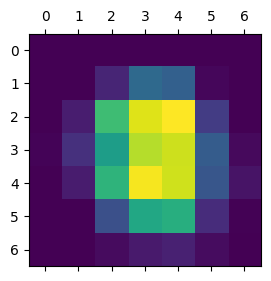

In [ ]:
#visualizing the heatmap
plt.figure(figsize=(3,3))
plt.matshow(heatmap, fignum=1)

## Step_5: Superimpose

In order to superimpose the heatmap and the image, we need to:
  1. Rescale the values to the range: 0 - 255
  2. Make the heatmap to have 3 channels: R,G,B and mapping the values to colors according to their intensities
  3. Resizing the heatmap to the size of the image
  4. finally superimpose

### a. Rescaling to 0 - 255

In [ ]:
# Rescale heatmap to a range 0-255 because RGB values range from 0 - 255
heatmap = np.uint8(255 * heatmap)
print(heatmap.shape)
print(heatmap)

(7, 7)
[[  0   0   0   0   0   0   0]
 [  0   0  26  86  78   4   0]
 [  0  20 175 242 255  45   0]
 [  2  35 141 226 235  73   6]
 [  0  19 165 251 236  67  13]
 [  0   0  62 153 159  32   1]
 [  0   0   7  18  23   8   0]]


### b. Creating RGB channels

The matrix is converted into the heatmap by giving it RGB channels such that the values correspond to the color intensities. The highest values in the matrix correspond to shades of red and the lowest values correspond to the blue.

<ipython-input-80-e38f782b9a91>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


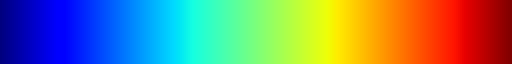

In [ ]:
# Use jet colormap to colorize the heatmap corresponding the the intensities
jet = cm.get_cmap("jet")
jet

In [ ]:
# Use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
print(jet_colors.shape)

(256, 3)


shape of jet_heatmap: (7, 7, 3)


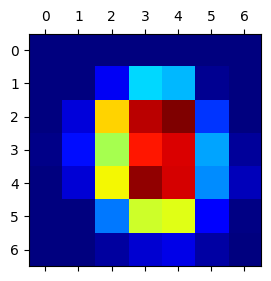

In [ ]:
jet_heatmap = jet_colors[heatmap]
print("shape of jet_heatmap:", jet_heatmap.shape)

#visualizing the heatmap
plt.figure(figsize=(3,3))
plt.matshow(jet_heatmap, fignum=1)

### c. Resizing the heatmap

Now resized the colorized heatmap to the original dimensions of the image. Tensorflow can be used to easily resize "images" with a single function.

(480, 640, 3)

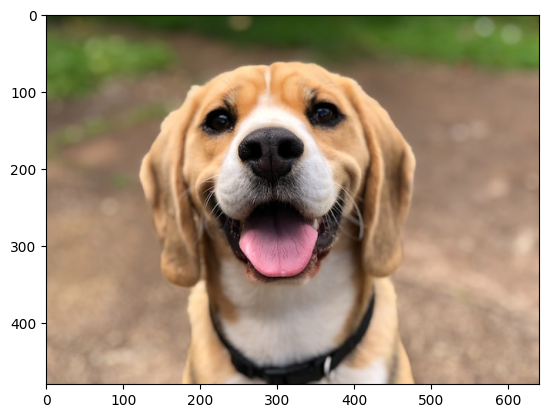

In [ ]:
#reloading the original image in its true dimensions
img = keras.utils.load_img(img_path)
#visualizing the image
plt.imshow(img)
img = keras.utils.img_to_array(img)
img.shape

Color mode of the heatmap: RGB
size of heatmap after resizing: (480, 640, 3)


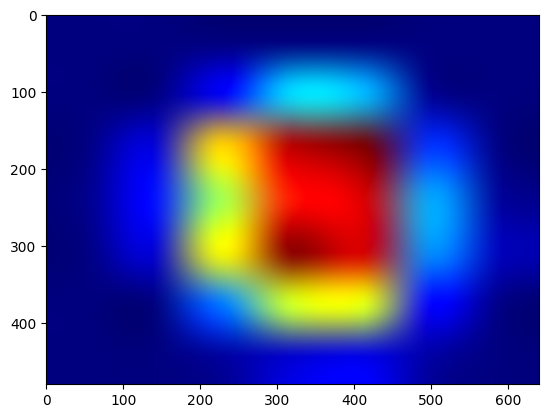

In [ ]:
# Converting the heatmap from array to image to resize it to the size of the original image
jet_heatmap = keras.utils.array_to_img(jet_heatmap)
print("Color mode of the heatmap:", jet_heatmap.mode)

#target size
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
#visualizing the heatmap
plt.imshow(jet_heatmap)

jet_heatmap = keras.utils.img_to_array(jet_heatmap)
print("size of heatmap after resizing:", jet_heatmap.shape)

### d. Finally superimposing

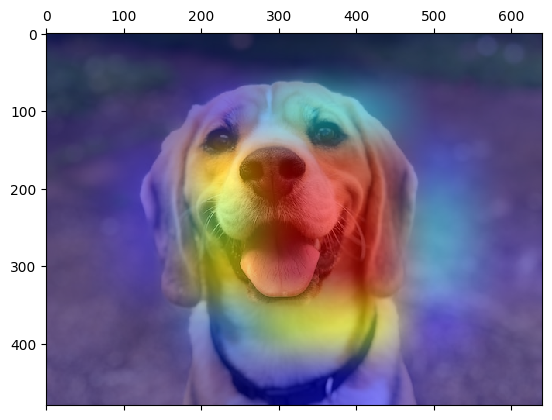

In [ ]:
#intensity control
alpha = 1

# Superimposing the heatmap on original image
superimposed_img = jet_heatmap * alpha + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

#visualizing the grad_cam
plt.matshow(superimposed_img)

# Test

In [ ]:
imgs_cats = []
imgs_dogs = []
main_dir = "/content/drive/MyDrive/Cats_vs_Dogs_Lab_images"

for i in listdir(main_dir):
  if(i == "weights.h5"): continue
  path = os.path.join(main_dir, i)
  img = keras.utils.img_to_array(keras.utils.load_img(path, target_size = (224, 224)))
  if("cat" in i):
    imgs_cats.append(img)
  elif("dog" in i):
    imgs_dogs.append(img)

imgs_cats_org = []
imgs_dogs_org = []
for i in listdir(main_dir):
  if(i == "weights.h5"): continue
  path = os.path.join(main_dir, i)
  img = keras.utils.img_to_array(keras.utils.load_img(path))
  if("cat" in i):
    imgs_cats_org.append(img)
  elif("dog" in i):
    imgs_dogs_org.append(img)

imgs_cats = np.array(imgs_cats)
imgs_dogs = np.array(imgs_dogs)
imgs_cats_org = np.array(imgs_cats_org)
imgs_dogs_org = np.array(imgs_dogs_org)

print(imgs_cats.shape)
print(imgs_dogs.shape)
print(imgs_cats_org.shape)
print(imgs_dogs_org.shape)

(3, 224, 224, 3)
(3, 224, 224, 3)
(3,)
(3,)


<ipython-input-64-a91cc87cd882>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgs_cats_org = np.array(imgs_cats_org)
<ipython-input-64-a91cc87cd882>:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgs_dogs_org = np.array(imgs_dogs_org)


In [ ]:
weights_path = "/content/drive/MyDrive/Cats_vs_Dogs_Lab_images/weights.h5"
classes = 2
activation = "softmax"
grad_model = create_grad_model_base(weights_path, classes, activation, base_model)

In [ ]:
grad_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,568,898
Trainable params: 4,098
Non-trainable params: 23,564,800
___________________________________________

In [ ]:
#making grad_cams with respect to cat class
class_index = 0
#removing the activation of last layer to get the raw scores rather than predictions
grad_model.layers[-1].activation = None

with tf.GradientTape() as tape:
  #predicting the image to get the the last conv output and predictions
  maps, preds = grad_model(imgs_cats)
  #getting the raw score of the interested class
  class_channel = preds[:, class_index]
  print("shape of last conv output:", maps.shape)
print()
print("raw scores:", preds.numpy())
print("raw scores of interested class:", class_channel.numpy())

shape of last conv output: (3, 5, 5, 2048)

raw scores: [[ 7.0741043  -8.3527775 ]
 [-0.19768417 -1.3808984 ]
 [ 3.2838967  -3.8574224 ]]
raw scores of interested class: [ 7.0741043  -0.19768417  3.2838967 ]


In [ ]:
# TAKING THE DERIVATIVE
# the shape of the derivative will be the same as the shape of last conv output
grads = tape.gradient(class_channel, maps)
print(grads.shape)

(3, 5, 5, 2048)


In [ ]:
gap_grads = []
for i in grads:
  print(i.shape)
  # global average pooling of each feature map
  gap = tf.reduce_mean(i, axis=(0, 1))
  gap_grads.append(gap)
  #notice that the lenght of the of the result is equal to the depth of the derivative
  print(gap.shape)
gap_grads = np.array(gap_grads)
print(gap_grads.shape)

(5, 5, 2048)
(2048,)
(5, 5, 2048)
(2048,)
(5, 5, 2048)
(2048,)
(3, 2048)


In [ ]:
heatmaps = []
for i in range(len(maps)):
  #multiplying each pooled value with its correponding feature map
  heatmap = maps[i] @ gap_grads[i][..., tf.newaxis]
  print(heatmap.shape)
  #removing the extra dimensions of value 1
  heatmap = tf.squeeze(heatmap)
  # For visualization purpose, we will normalize the heatmap between 0 & 1
  heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
  heatmaps.append(heatmap)
heatmaps = np.array(heatmaps)
print(heatmaps.shape)

(5, 5, 1)
(5, 5, 1)
(5, 5, 1)
(3, 5, 5)


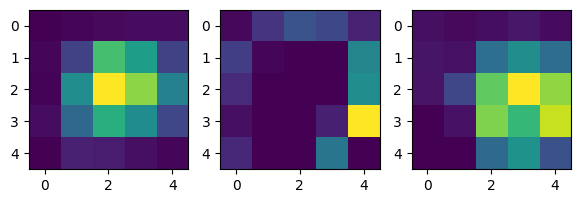

In [ ]:
#visualizing the heatmap
fig, ax = plt.subplots(1,3, figsize=(7,5))
ax[0].imshow(heatmaps[0])
ax[1].imshow(heatmaps[1])
ax[2].imshow(heatmaps[2])

In [ ]:
# Rescale heatmaps to a range 0-255 because RGB values range from 0 - 255
heatmaps = np.uint8(255 * heatmaps)
print(heatmaps.shape)
print(heatmaps)

(3, 5, 5)
[[[  0   3   6   8   8]
  [  3  49 179 141  48]
  [  2 125 255 210 111]
  [  8  86 161 124  53]
  [  0  23  20  10   4]]

 [[  5  38  65  55  24]
  [ 47   3   0   0 115]
  [ 31   0   0   0 125]
  [ 10   0   0  22 255]
  [ 29   0   0  99   0]]

 [[ 10   6   9  16   7]
  [ 13  11  93 126  90]
  [ 13  54 192 255 212]
  [  0  12 206 169 233]
  [  0   0  87 131  63]]]


<ipython-input-49-e38f782b9a91>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


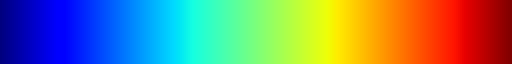

In [ ]:
# Use jet colormap to colorize the heatmap corresponding the the intensities
jet = cm.get_cmap("jet")
jet

In [ ]:
# Use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
print(jet_colors.shape)

(256, 3)


shape of jet_heatmaps: (3, 5, 5, 3)


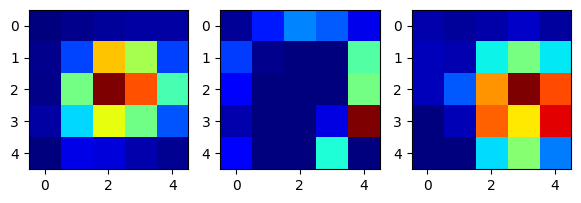

In [ ]:
jet_heatmaps = jet_colors[heatmaps]
print("shape of jet_heatmaps:", jet_heatmaps.shape)

#visualizing the heatmap
fig, ax = plt.subplots(1,3, figsize=(7,5))
ax[0].imshow(jet_heatmaps[0])
ax[1].imshow(jet_heatmaps[1])
ax[2].imshow(jet_heatmaps[2])

Color mode of the heatmap: RGB
size of heatmap after resizing: (440, 640, 3)
Color mode of the heatmap: RGB
size of heatmap after resizing: (960, 640, 3)
Color mode of the heatmap: RGB
size of heatmap after resizing: (427, 640, 3)


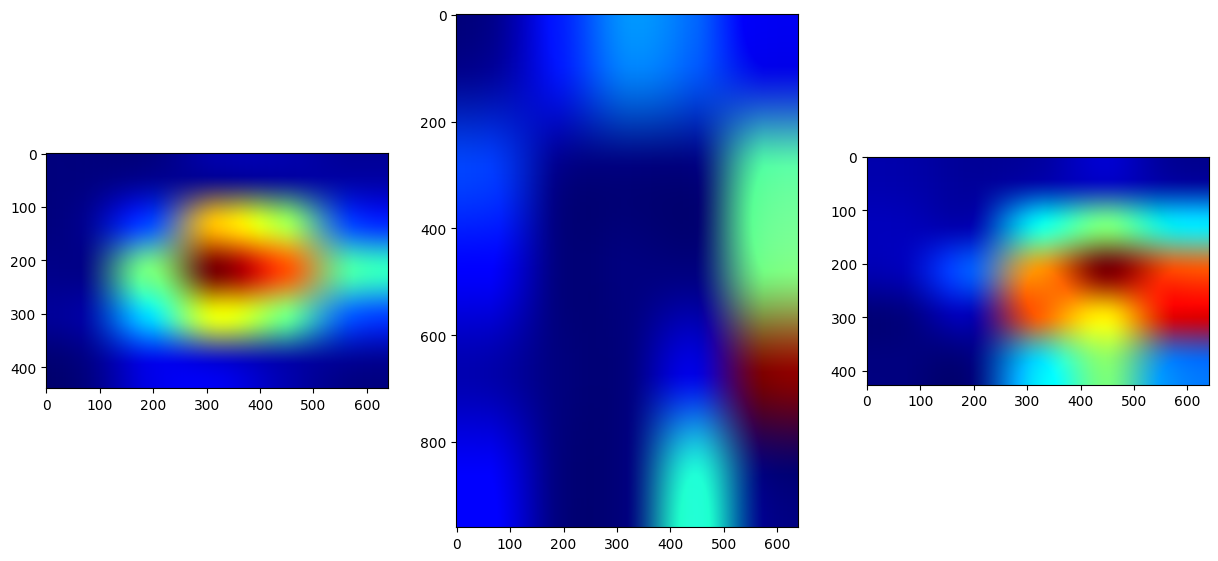

In [ ]:
jet_heatmaps_resized = []
for i in range(len(jet_heatmaps)):

  # Converting the heatmap from array to image to resize it to the size of the original image
  jet_heatmap = keras.utils.array_to_img(jet_heatmaps[i])
  print("Color mode of the heatmap:", jet_heatmap.mode)

  #target size
  jet_heatmap = jet_heatmap.resize((imgs_cats_org[i].shape[1], imgs_cats_org[i].shape[0]))

  jet_heatmap = keras.utils.img_to_array(jet_heatmap)
  print("size of heatmap after resizing:", jet_heatmap.shape)
  jet_heatmaps_resized.append(jet_heatmap)

#visualizing the heatmap
fig, ax = plt.subplots(1,3, figsize=(15,10))
ax[0].imshow(jet_heatmaps_resized[0].astype('uint8'))
ax[1].imshow(jet_heatmaps_resized[1].astype('uint8'))
ax[2].imshow(jet_heatmaps_resized[2].astype('uint8'))

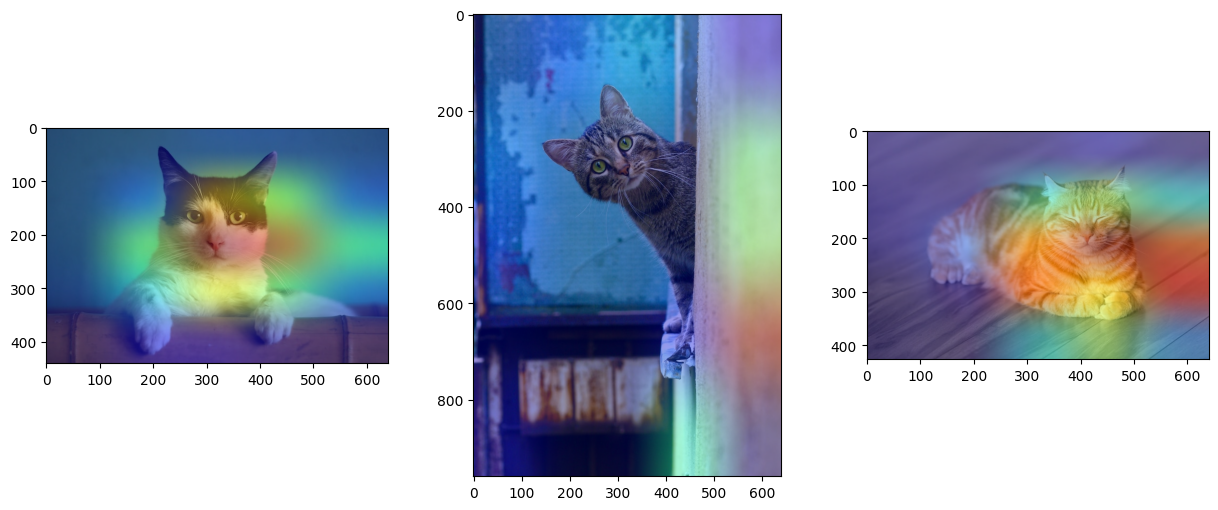

In [ ]:
#intensity control
alpha = 0.7

superimposed_imgs = []
for i in range(len(jet_heatmaps_resized)):
  # Superimposing the heatmap on original image
  superimposed_img = jet_heatmaps_resized[i] * alpha + imgs_cats_org[i]
  superimposed_img = keras.utils.array_to_img(superimposed_img)
  superimposed_imgs.append(superimposed_img)

#visualizing the grad_cams
fig, ax = plt.subplots(1,3, figsize=(15,6))
ax[0].imshow(superimposed_imgs[0])
ax[1].imshow(superimposed_imgs[1])
ax[2].imshow(superimposed_imgs[2])

<ipython-input-62-231a7c0dbb30>:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


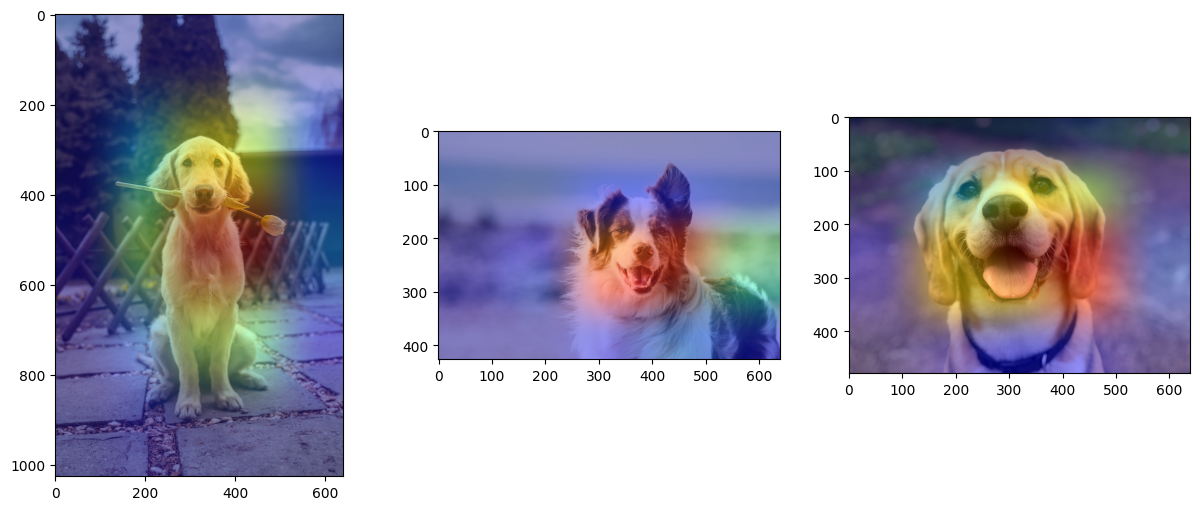

In [ ]:
#making grad_cams with respect to dog class
class_index = 1
#removing the activation of last layer to get the raw scores rather than predictions
grad_model.layers[-1].activation = None

with tf.GradientTape() as tape:
  #predicting the image to get the the last conv output and predictions
  maps, preds = grad_model(imgs_dogs)
  #getting the raw score of the interested class
  class_channel = preds[:, class_index]
#   print("shape of last conv output:", maps.shape)
# print()
# print("raw scores:", preds.numpy())
# print("raw scores of interested class:", class_channel.numpy())

# TAKING THE DERIVATIVE
# the shape of the derivative will be the same as the shape of last conv output
grads = tape.gradient(class_channel, maps)
# print(grads.shape)

gap_grads = []
for i in grads:
  # print(i.shape)
  # global average pooling of each feature map
  gap = tf.reduce_mean(i, axis=(0, 1))
  gap_grads.append(gap)
  #notice that the lenght of the of the result is equal to the depth of the derivative
  # print(gap.shape)
gap_grads = np.array(gap_grads)
# print(gap_grads.shape)

heatmaps = []
for i in range(len(maps)):
  #multiplying each pooled value with its correponding feature map
  heatmap = maps[i] @ gap_grads[i][..., tf.newaxis]
  # print(heatmap.shape)
  #removing the extra dimensions of value 1
  heatmap = tf.squeeze(heatmap)
  # For visualization purpose, we will normalize the heatmap between 0 & 1
  heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
  heatmaps.append(heatmap)
heatmaps = np.array(heatmaps)
# print(heatmaps.shape)

# #visualizing the heatmap
# fig, ax = plt.subplots(1,3, figsize=(7,5))
# ax[0].imshow(heatmaps[0])
# ax[1].imshow(heatmaps[1])
# ax[2].imshow(heatmaps[2])

# Rescale heatmaps to a range 0-255 because RGB values range from 0 - 255
heatmaps = np.uint8(255 * heatmaps)
# print(heatmaps.shape)
# print(heatmaps)

# Use jet colormap to colorize the heatmap corresponding the the intensities
jet = cm.get_cmap("jet")
# jet

# Use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
# print(jet_colors.shape)

jet_heatmaps = jet_colors[heatmaps]
# print("shape of jet_heatmaps:", jet_heatmaps.shape)

# #visualizing the heatmap
# fig, ax = plt.subplots(1,3, figsize=(7,5))
# ax[0].imshow(jet_heatmaps[0])
# ax[1].imshow(jet_heatmaps[1])
# ax[2].imshow(jet_heatmaps[2])

jet_heatmaps_resized = []
for i in range(len(jet_heatmaps)):

  # Converting the heatmap from array to image to resize it to the size of the original image
  jet_heatmap = keras.utils.array_to_img(jet_heatmaps[i])
  # print("Color mode of the heatmap:", jet_heatmap.mode)

  #target size
  jet_heatmap = jet_heatmap.resize((imgs_dogs_org[i].shape[1], imgs_dogs_org[i].shape[0]))

  jet_heatmap = keras.utils.img_to_array(jet_heatmap)
  # print("size of heatmap after resizing:", jet_heatmap.shape)
  jet_heatmaps_resized.append(jet_heatmap)

# #visualizing the heatmap
# fig, ax = plt.subplots(1,3, figsize=(15,10))
# ax[0].imshow(jet_heatmaps_resized[0].astype('uint8'))
# ax[1].imshow(jet_heatmaps_resized[1].astype('uint8'))
# ax[2].imshow(jet_heatmaps_resized[2].astype('uint8'))

#intensity control
alpha = 0.7

superimposed_imgs = []
for i in range(len(jet_heatmaps_resized)):
  # Superimposing the heatmap on original image
  superimposed_img = jet_heatmaps_resized[i] * alpha + imgs_dogs_org[i]
  superimposed_img = keras.utils.array_to_img(superimposed_img)
  superimposed_imgs.append(superimposed_img)

#visualizing the grad_cams
fig, ax = plt.subplots(1,3, figsize=(15,6))
ax[0].imshow(superimposed_imgs[0])
ax[1].imshow(superimposed_imgs[1])
ax[2].imshow(superimposed_imgs[2])

# Creating gradcams of multi images

In [ ]:
weights_path = "/content/drive/MyDrive/Cats_vs_Dogs_Lab_images/weights.h5"
classes = 2
activation = "softmax"
grad_model = create_grad_model_base(weights_path, classes, activation, base_model)
grad_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,568,898
Trainable params: 4,098
Non-trainable params: 23,564,800
___________________________________________

<ipython-input-46-2488d385bbf8>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


<Figure size 640x480 with 0 Axes>

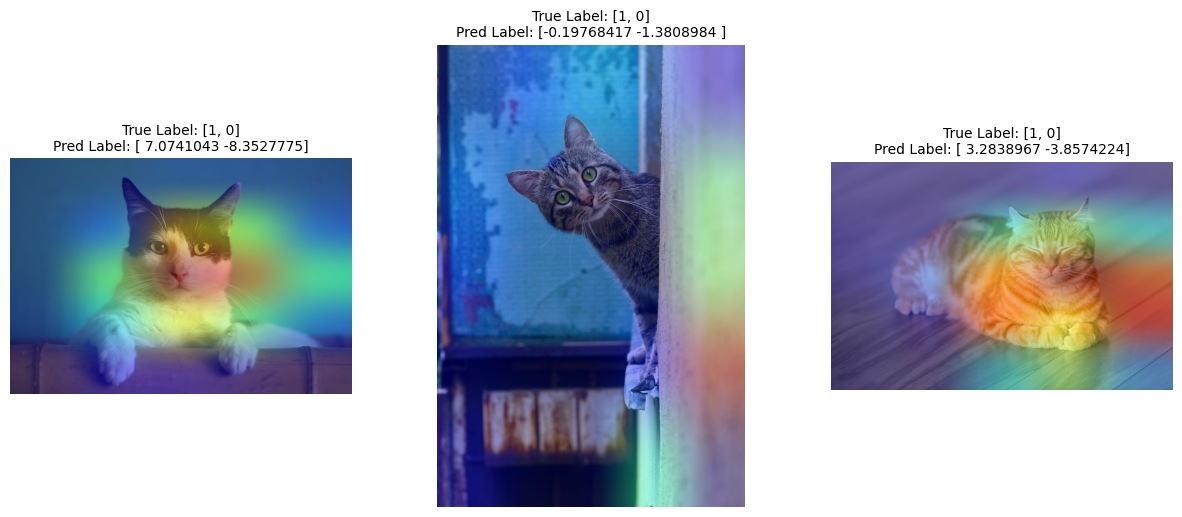

In [ ]:
heatmaps, y_preds = create_heatmaps_multi(grad_model, imgs_cats, 0)
gradcams = superimpose_multi(heatmaps, imgs_cats_org, alpha = 0.7)

show_imgs(gradcams, [[1,0],[1,0],[1,0]], [15,6], 3, labels_f = y_preds)

<ipython-input-44-775ba85fa298>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


<Figure size 640x480 with 0 Axes>

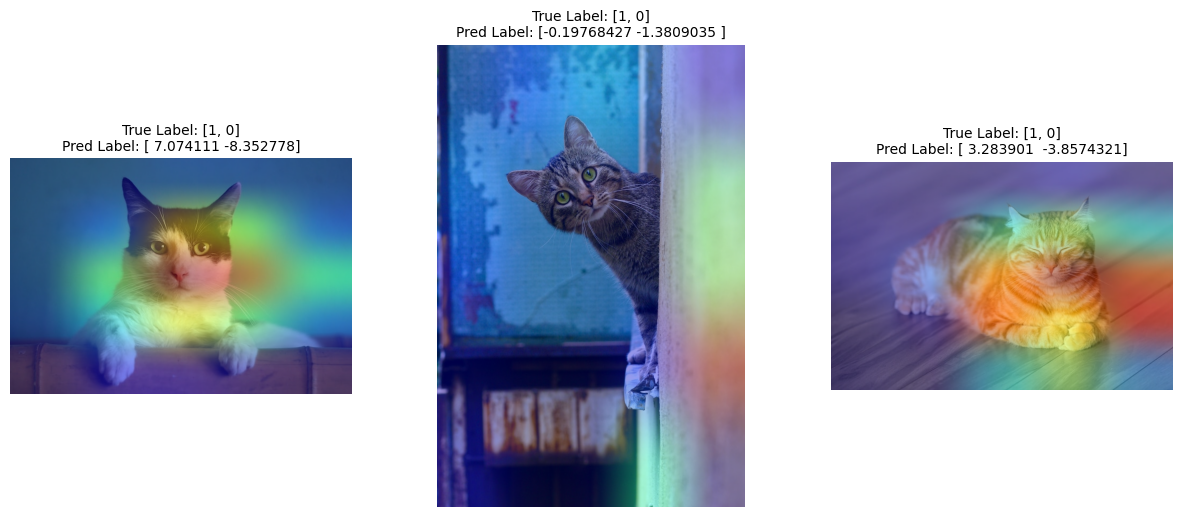

In [ ]:
grad_cams = []
y_preds = []
for i in range(len(imgs_cats)):
  heatmap, y_pred = create_heatmaps_single(grad_model, tf.expand_dims(imgs_cats[i], axis = 0), 0)
  gradcam = superimpose_single(heatmap, imgs_cats_org[i], alpha = 0.7)
  grad_cams.append(gradcam)
  y_preds.append(y_pred[0])

show_imgs(grad_cams, [[1,0],[1,0],[1,0]], [15,6], 3, y_preds)

<ipython-input-43-dcf5b7014588>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


<Figure size 640x480 with 0 Axes>

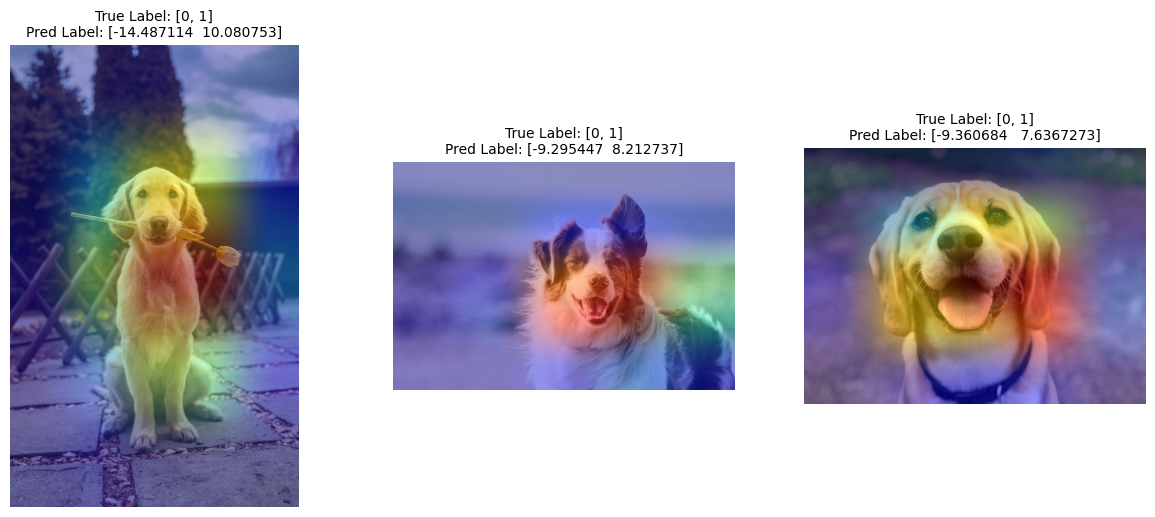

In [ ]:
heatmaps, y_preds = create_heatmaps_multi(grad_model, imgs_dogs, 1)
gradcams = superimpose_multi(heatmaps, imgs_dogs_org, alpha = 0.7)

show_imgs(gradcams, [[0,1],[0,1],[0,1]], [15,6], 3, labels_f = y_preds)

<ipython-input-44-775ba85fa298>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


<Figure size 640x480 with 0 Axes>

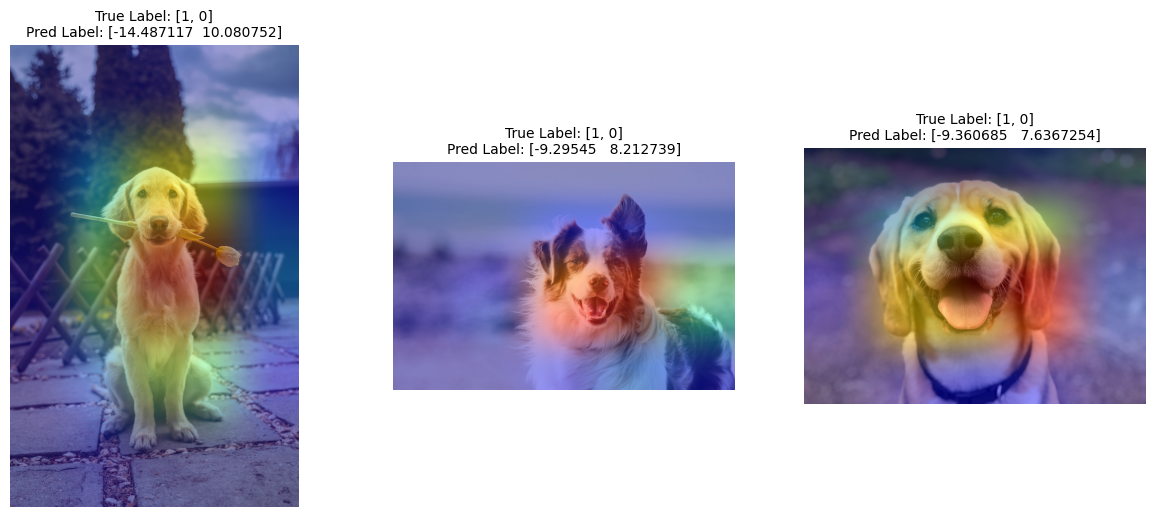

In [ ]:
grad_cams = []
y_preds = []
for i in range(len(imgs_dogs)):
  heatmap, y_pred = create_heatmaps_single(grad_model, tf.expand_dims(imgs_dogs[i], axis = 0), 1)
  gradcam = superimpose_single(heatmap, imgs_dogs_org[i], alpha = 0.7)
  grad_cams.append(gradcam)
  y_preds.append(y_pred[0])

show_imgs(grad_cams, [[1,0],[1,0],[1,0]], [15,6], 3, y_preds)

# Grad_Cams from different conv layers

In order to further understand the behaviour of our CNN model, we will generate grad_cams by using convolution outputs of intermediate layers. This will allow us to analyse the learning the model at different stages.

In this task, you will not construct a transfer learning model, instead you will use only the base model to make the grad_cam models because Tensorflow does not provide the functionality to access the internal layers' outputs of a base model.

---

In order to use the base model's outputs you have to use the decode_predictions method of your base_model to decode the predictions.
Same is the case with the inputs.

Refer https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet_v2/decode_predictions

and

https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet_v2/preprocess_input

for further details.

In [ ]:
#loading the model
base_model = keras.applications.ResNet50V2(
    # weights = "../input/ResNet50V2/xception_weights_tf_dim_ordering_tf_kernels_notop.h5",
    input_shape = (224,224,3),
    include_top = True)

base_model.trainable = False
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input
decode_predictions = tf.keras.applications.resnet_v2.decode_predictions

102869336/102869336 [==============================] - 4s 0us/step


In [ ]:
# keras.utils.plot_model(base_model)

In [ ]:
# for i in range(len(base_model.layers)):
#   print("[" + str(i) + "]:", end = " ")
#   print(base_model.layers[i].name)

You may select any two conv outputs, one must be from the first quarter and the second from the 2nd or 3rd quarter.

Make two grad_models that will provide the above mentioned outputs.

Then use those models to generate grad_cams of a single image at different levels.

In [ ]:
print(base_model.layers[39].output)
print(base_model.layers[153].output)

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 256), dtype=tf.float32, name=None), name='conv2_block3_out/add:0', description="created by layer 'conv2_block3_out'")
KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 1024), dtype=tf.float32, name=None), name='conv4_block6_out/add:0', description="created by layer 'conv4_block6_out'")


In [ ]:
#grad_model giving out of last conv of conv2_block3
grad_model_start = Model(inputs = base_model.inputs, outputs = [base_model.get_layer(index = 38).output, base_model.output])

#grad_model giving out of last conv of conv2_block3
grad_model_mid = Model(inputs = base_model.inputs, outputs = [base_model.get_layer(index = 153).output, base_model.output])

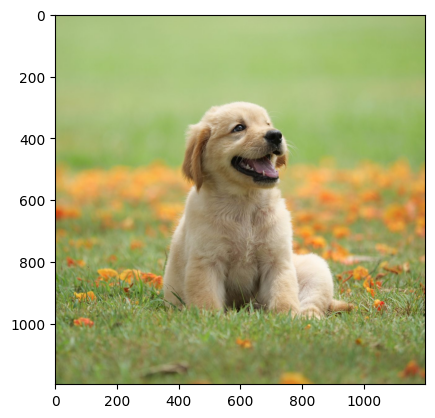

In [ ]:
main_dir = "/content/drive/MyDrive/Cats_vs_Dogs_Lab_images"
path = "/cat_3.jpg"

# img_path = main_dir + path
img_path = "/content/dog.jpg"

img_org = keras.utils.load_img(img_path)
#visualizing the image
plt.imshow(img_org)
img_org = keras.utils.img_to_array(img_org)

In [ ]:
img = keras.utils.load_img(img_path, target_size = (224, 224))
img = keras.utils.img_to_array(img)
img.shape

img_t = tf.expand_dims(img, axis = 0)
img_t = preprocess_input(img_t)
print(img_t.shape)
preds = base_model.predict(img_t)
decode_predictions(preds, top=1)[0]

(1, 224, 224, 3)
1/1 [==============================] - 0s 38ms/step


[('n02099601', 'golden_retriever', 0.87025183)]

<ipython-input-146-775ba85fa298>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")



[463.56732]


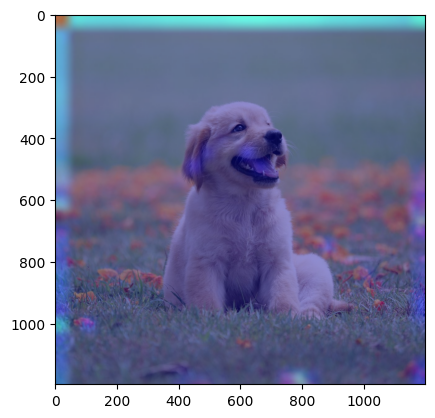

In [ ]:
# heatmap, y_pred = create_heatmaps_single(grad_model_start, img, 0, choose_mode = 1)
heatmap, y_pred = create_heatmaps_single(grad_model_start, tf.expand_dims(img, axis = 0), 0, choose_mode = 1)
gradcam = superimpose_single(heatmap, img_org, alpha = 1)
print()
plt.imshow(gradcam)
print(y_pred)

<ipython-input-146-775ba85fa298>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


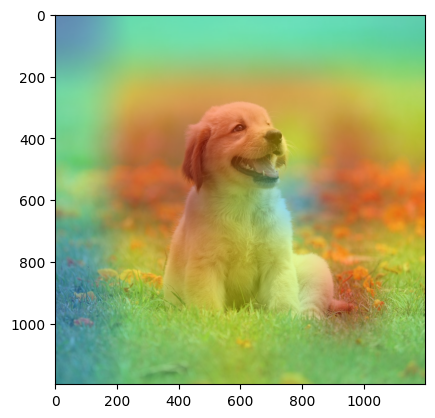

In [ ]:
heatmap, y_pred = create_heatmaps_single(grad_model_mid, tf.expand_dims(img, axis = 0), 0, choose_mode = 1)
gradcam = superimpose_single(heatmap, img_org, alpha = 0.7)
plt.imshow(gradcam)

In [ ]:
img_size = (160, 160)
img = keras.utils.load_img(img_path, target_size=img_size)
img = keras.utils.img_to_array(img)
img = np.expand_dims(img, axis=0)
img.shape

heatmap, y_pred = create_heatmaps_single(grad_model, img, 0, choose_mode = 1)
gradcam = superimpose_single(heatmap, img_org, alpha = 0.7)
plt.imshow(gradcam)

# Test

<ipython-input-9-775ba85fa298>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


<Figure size 640x480 with 0 Axes>

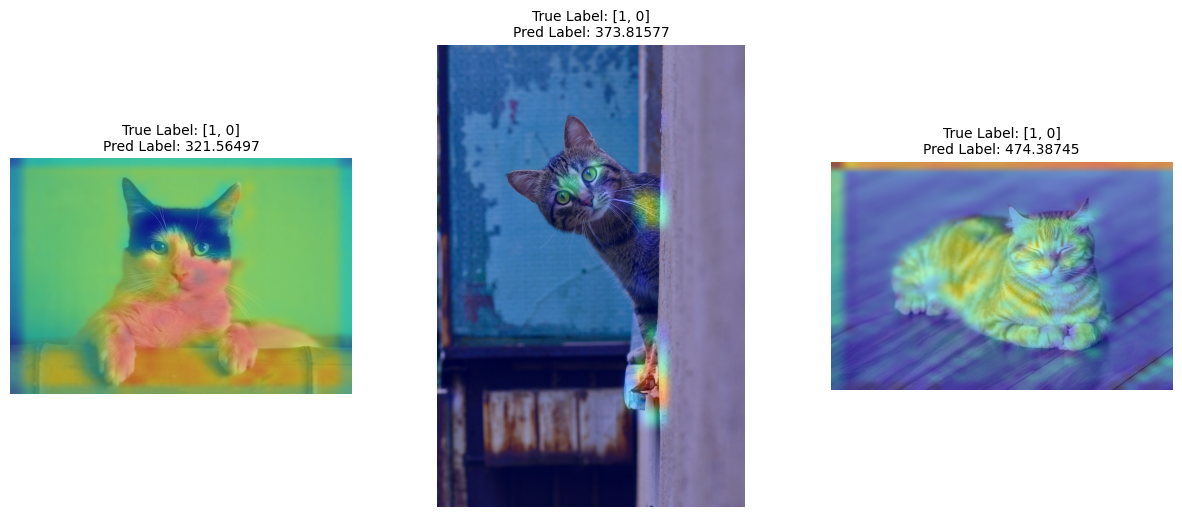

In [ ]:
grad_cams = []
y_preds = []
for i in range(len(imgs_cats)):
  heatmap, y_pred = create_heatmaps_single(grad_model_start, tf.expand_dims(imgs_cats[i], axis = 0), 0, choose_mode = 1)
  gradcam = superimpose_single(heatmap, imgs_cats_org[i], alpha = 0.7)
  grad_cams.append(gradcam)
  y_preds.append(y_pred[0])

show_imgs(grad_cams, [[1,0],[1,0],[1,0]], [15,6], 3, y_preds)

<ipython-input-160-775ba85fa298>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


<Figure size 640x480 with 0 Axes>

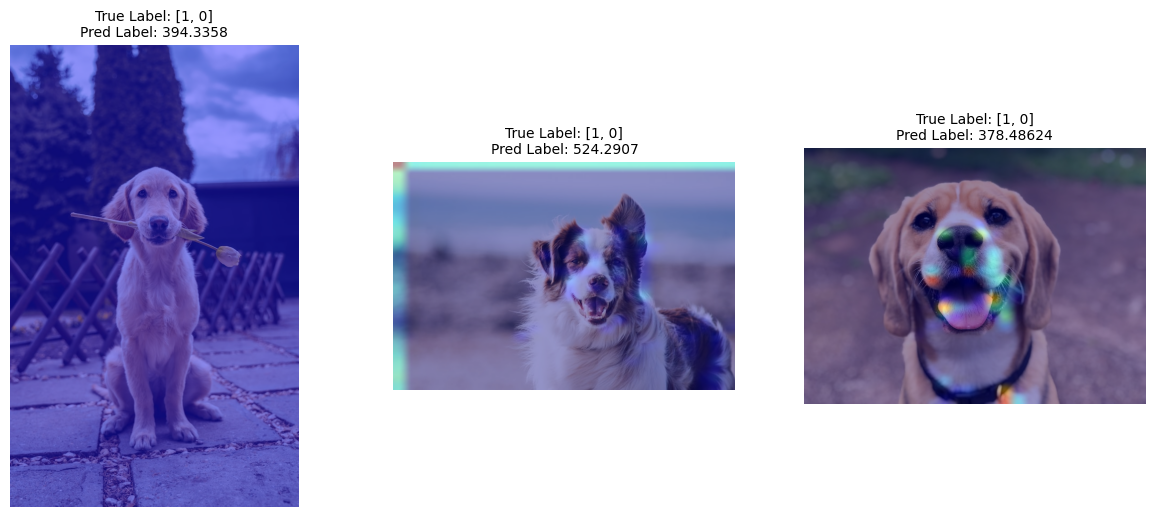

In [ ]:
# grad_cams = []
# y_preds = []
# for i in range(len(imgs_dogs)):
#   heatmap, y_pred = create_heatmaps_single(grad_model_start, tf.expand_dims(imgs_dogs[i], axis = 0), 0, choose_mode = 1)
#   gradcam = superimpose_single(heatmap, imgs_dogs_org[i], alpha = 0.7)
#   grad_cams.append(gradcam)
#   y_preds.append(y_pred[0])

# show_imgs(grad_cams, [[1,0],[1,0],[1,0]], [15,6], 3, y_preds)

<ipython-input-159-dcf5b7014588>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


<Figure size 640x480 with 0 Axes>

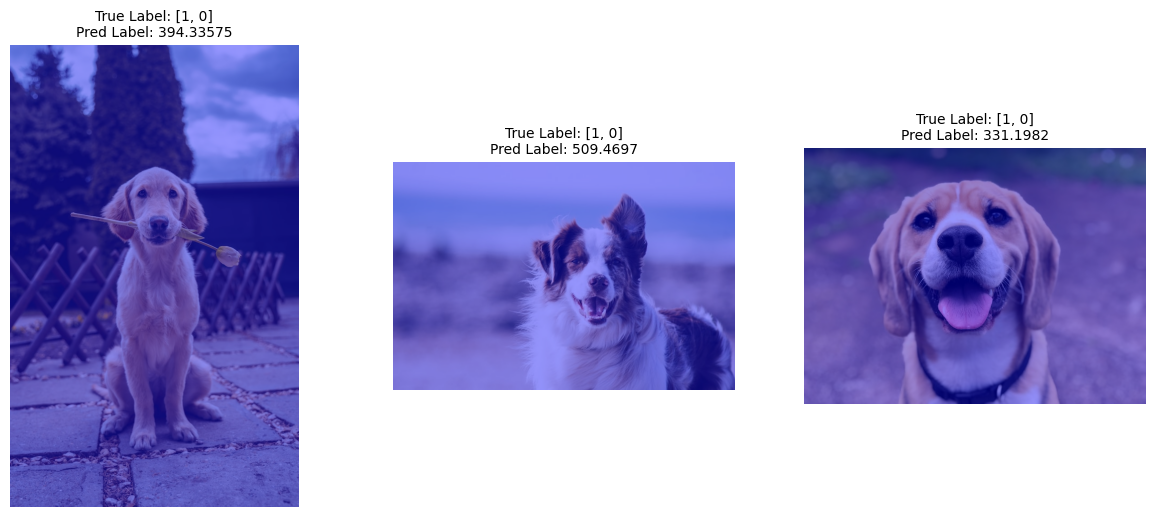

In [ ]:
# heatmaps, y_preds = create_heatmaps_multi(grad_model_start, imgs_dogs, 0, choose_mode = 1)
# gradcams = superimpose_multi(heatmaps, imgs_dogs_org, alpha = 0.7)

# show_imgs(gradcams, [[1,0],[1,0],[1,0]], [15,6], 3, labels_f = y_preds)

<ipython-input-159-dcf5b7014588>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


<Figure size 640x480 with 0 Axes>

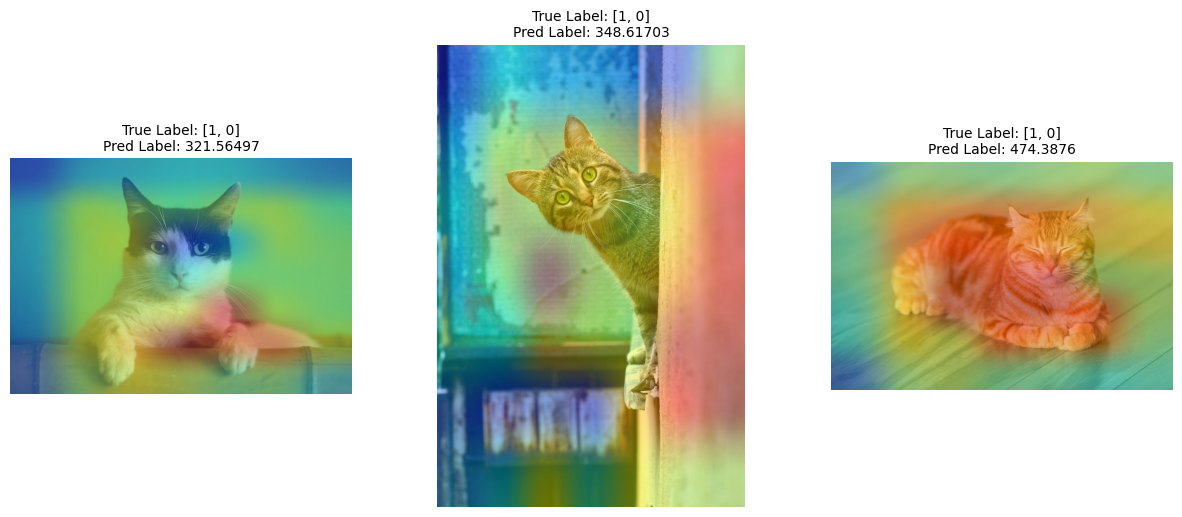

In [ ]:
heatmaps, y_preds = create_heatmaps_multi(grad_model_mid, imgs_cats, 0, choose_mode = 1)
gradcams = superimpose_multi(heatmaps, imgs_cats_org, alpha = 0.7)

show_imgs(gradcams, [[1,0],[1,0],[1,0]], [15,6], 3, labels_f = y_preds)

<ipython-input-159-dcf5b7014588>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


<Figure size 640x480 with 0 Axes>

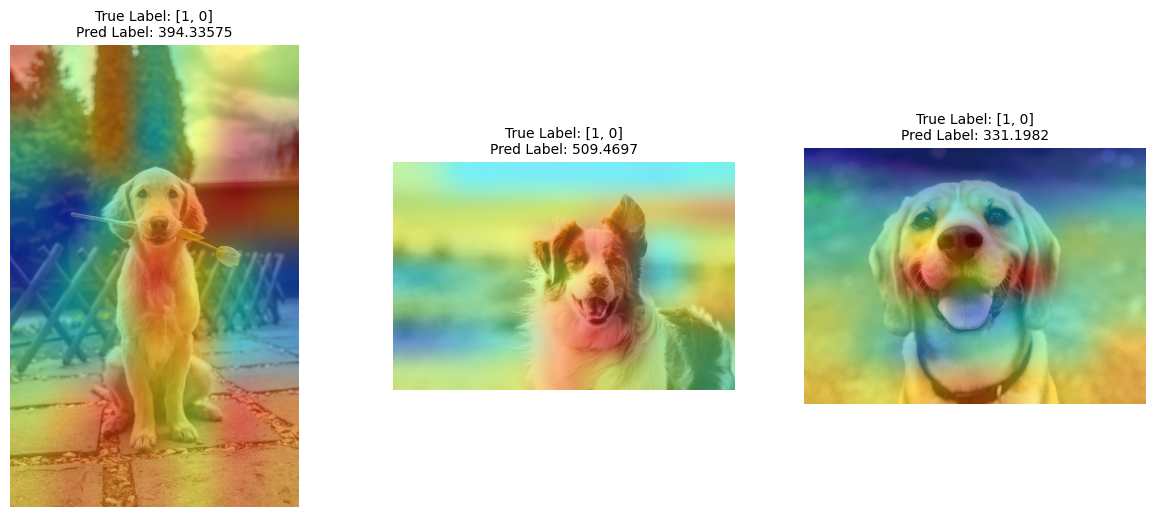

In [ ]:
heatmaps, y_preds = create_heatmaps_multi(grad_model_mid, imgs_dogs, 0, choose_mode = 1)
gradcams = superimpose_multi(heatmaps, imgs_dogs_org, alpha = 0.9)

show_imgs(gradcams, [[1,0],[1,0],[1,0]], [15,6], 3, labels_f = y_preds)